# Introduction to Linear Algebra and the world of probablitites

In this work-sheet, we shall do two activities. First of all we shall check the power of SVD. Then we shall check how may we generate data from an arbitrary distribution (given that we have the ability to generate data from a uniform distribution).

## Singular Value Decomposition
Lets load an image and try to do it's SVD.

Please note the way to access an image from your Google drive. Change the code accordingly (and load an image in your Google drive) to access to your own image!

Mark that we shall be using PIL's Image library, a useful set of powerful algorithms for image processing.

Im using hard paths instad of google drive to save space on it :)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Lets load the image and convert that to a gray-scale version (so that we can treat it just like a 2D matrix). What will happen if its not gray-scale?

Anwser: if its not grayscale the svg wont work because the calculations expevt 2D matrix, correction it should work on any 2d matrix but in grayscale we can actually see something.

Mark how we have used the command $matrix$ to generate a matrix from the image!

In [21]:
img = Image.open("/home/scoora/Downloads/Kapitan_usmiech.JPG")
imggray = img.convert('L')

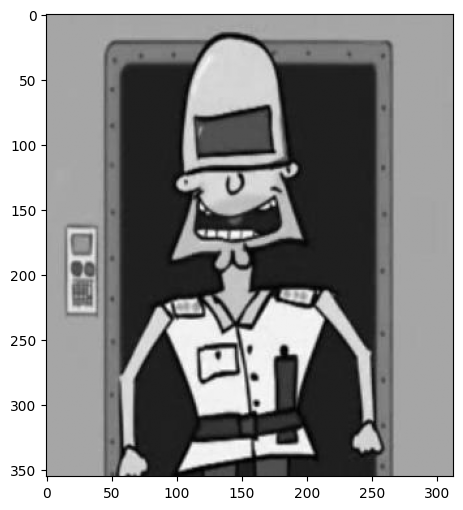

In [22]:
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray')

###SVD

We can directly use the $svd$ command from Numpy to operate SVD on the matrix.

Lets first check how the image will look if we only use a single vector to reconstruct the image.

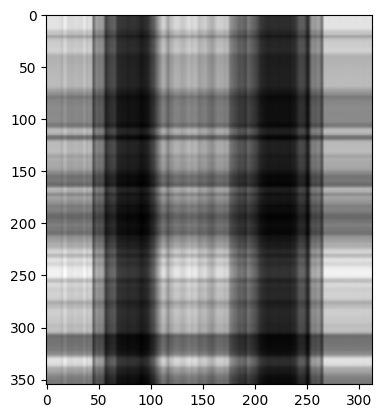

In [23]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');


Now lets check how does the sigma vector look like.

What do you observe? How many vecotrs can we use to get a decent reconstruction of the image?
What will happen if we omit the first 1-2 vectors (corresponding to the largest eigen values)?

anwser: for my test image around 50/313 vectors are enough, for sentinel images more close to 100 vectors due to bad spatial resolutions to see a bit granulated but enough sharp image to recognize what it represents, if we omit the firs vectors with highest eigen values, the image is very blurry. Also due to spectral resolution of the images for the forest area we need bit more vectors due to it being hardly recognizable just big lake of trees, for city its easier to distinguish buildings etc

(355, 355)
(313,)


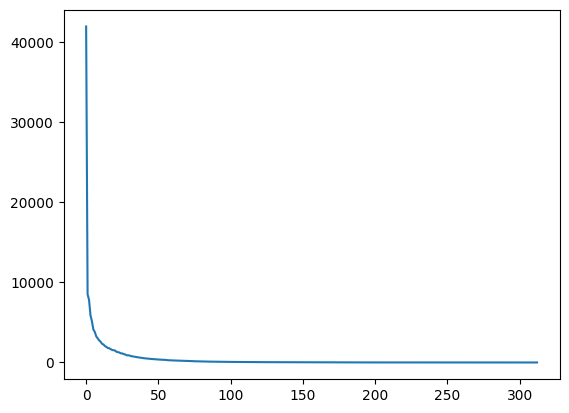

In [24]:
print(U.shape)
print(sigma.shape)
plt.plot(sigma)

Reconstruction with ommiting first values shows the image is very blurry in the highest "energy" points

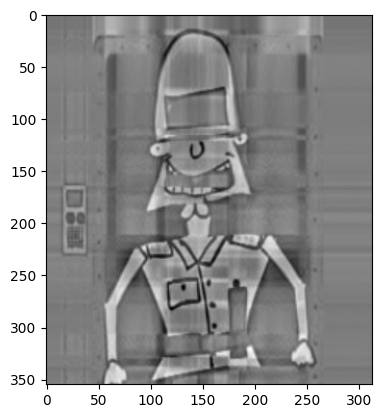

In [25]:
i = 60
j = 3
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

Reconstruction for different singular values

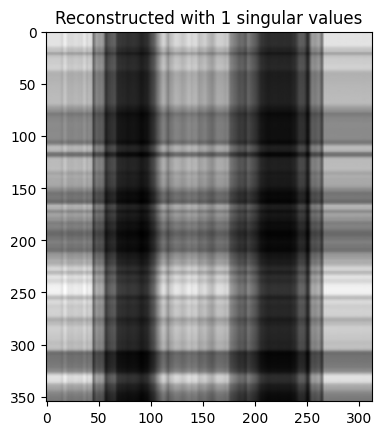

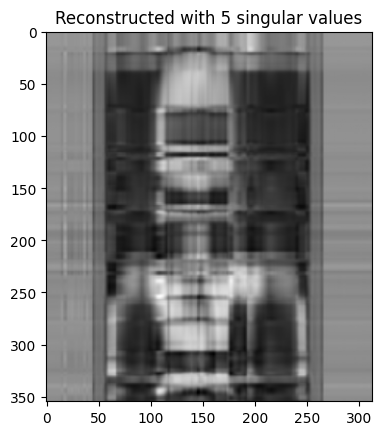

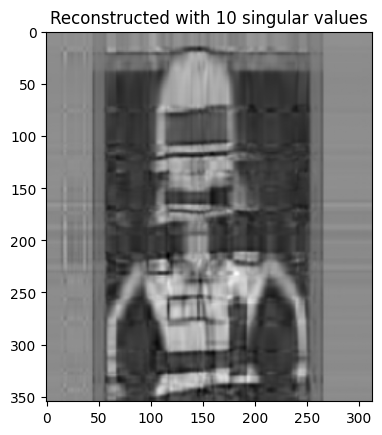

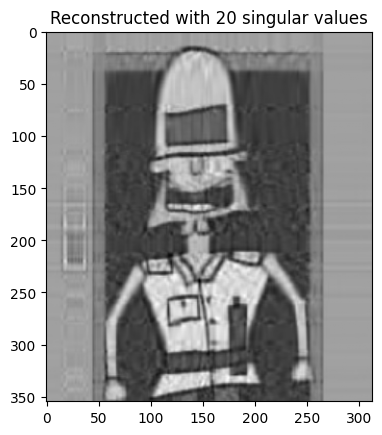

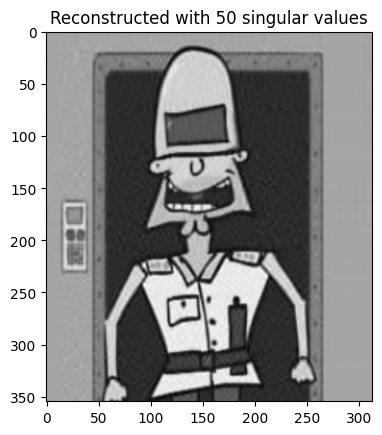

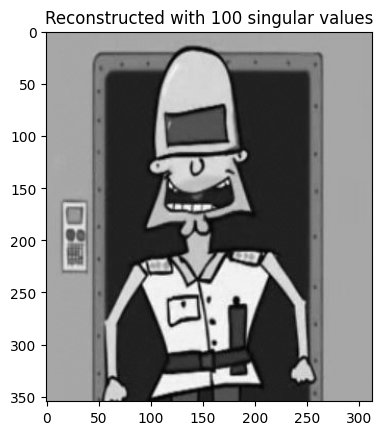

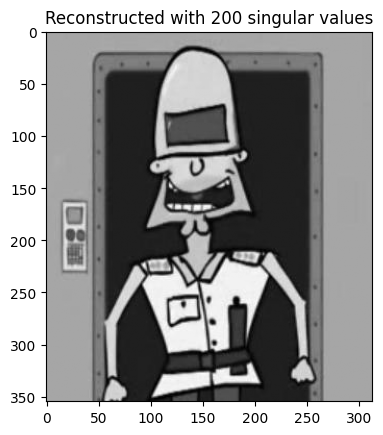

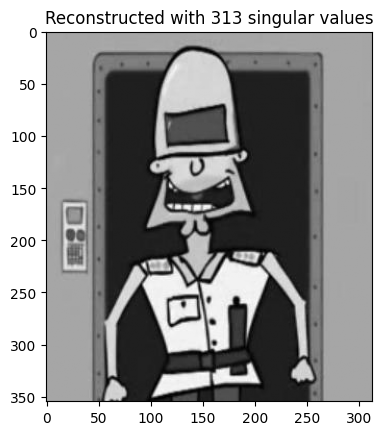

In [26]:
for k in [1, 5, 10, 20, 50, 100, 200, 313]:
    reconst = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    plt.imshow(reconst, cmap='gray')
    plt.title(f'Reconstructed with {k} singular values')
    plt.show()

## Sentinel-2 svd  (Should work with any tile containing Krakow)
Firstly we are going to calculate svd on a more urbanized area around Krakow's Main Square so we need to download the data, take rgb bands make a stack  normalize take only wanted area and finally convert to PIL image to input into code before for svd calculations.

Found bands: {'B04': '/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B04_10m.jp2', 'B03': '/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B03_10m.jp2', 'B02': '/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B02_10m.jp2'}


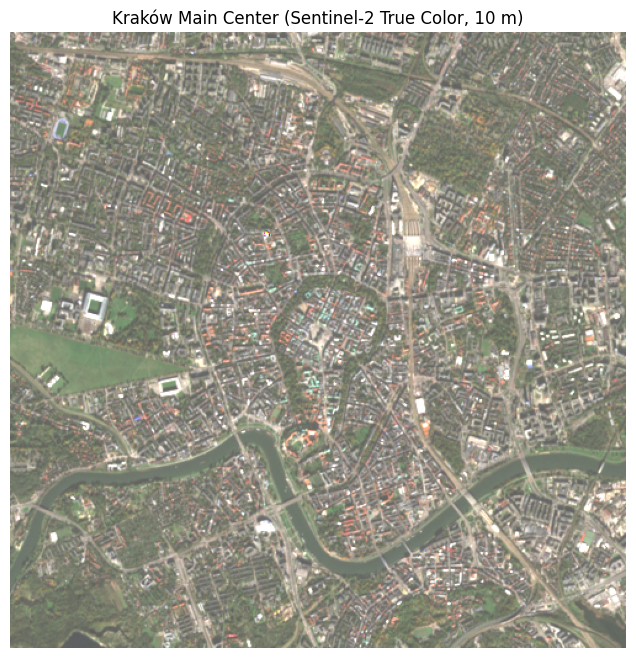

In [27]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from pyproj import Transformer
##path to the 10m bands 
folder = "/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/"
##paths to the r g and b bands 
band_paths = {b: glob.glob(f"{folder}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
print("Found bands:", band_paths)
##now we prepare to crop the image to a smaller area of interest 
lon, lat = 19.93722, 50.06143   # Rynek Główny coordinates
#we transform the image to easier pick the area of interest, we just take the lat lon of center of Krakow and ad 2500 m to each side 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 2500   
dy = 2500   
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

## healper functions to load only the cropped area of interest instead of whole image 
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data
##crop each band
b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax))  # Red
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax))  # Green
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax))  # Blue

#stack normalize and exclude outliers
rgb_crop = np.dstack((b4_crop, b3_crop, b2_crop)).astype(np.float32)
rgb_crop /= np.percentile(rgb_crop, 99)
rgb_crop = np.clip(rgb_crop, 0, 1)
#and we plot the results
plt.figure(figsize=(8, 8))
plt.imshow(rgb_crop)
plt.title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
plt.axis("off")
plt.show()


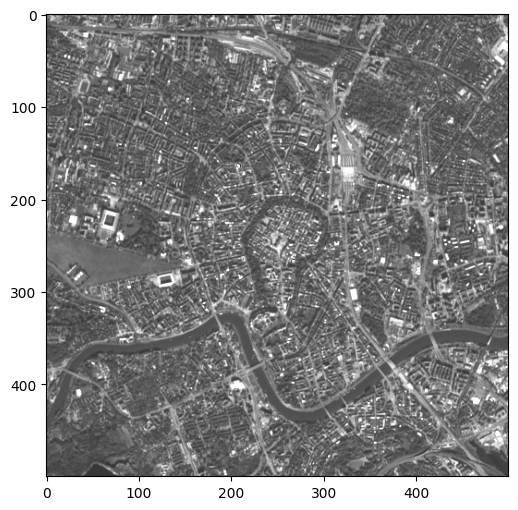

In [28]:
from PIL import Image
import numpy as np
#for the code before we need to transform the numpy array we have to the PIL image 
rgb_uint8 = (rgb_crop * 255).astype(np.uint8)
img = Image.fromarray(rgb_uint8)

##and as before:
imggray = img.convert('L')
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray')

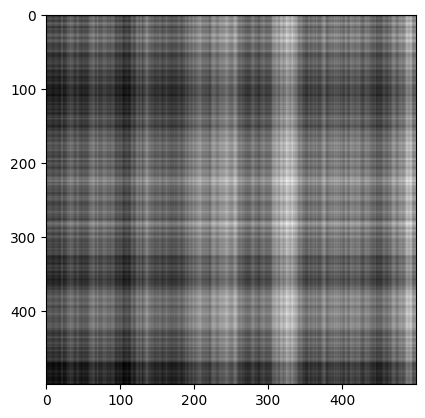

In [29]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

(500, 500)
(500,)


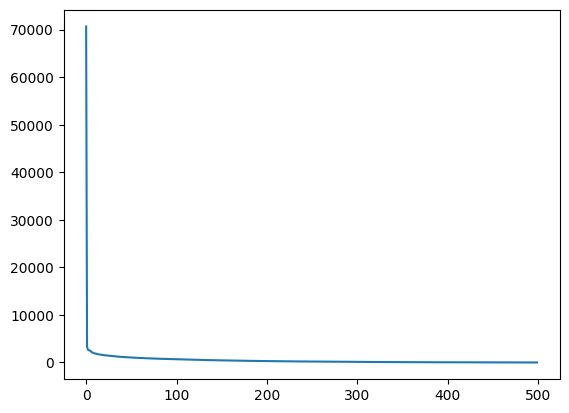

In [30]:
print(U.shape)
print(sigma.shape)
plt.plot(sigma)

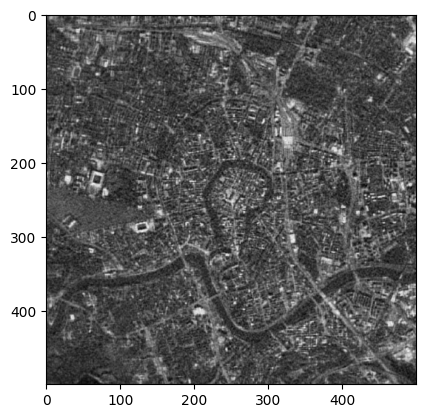

In [31]:
i = 90
j = 0
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

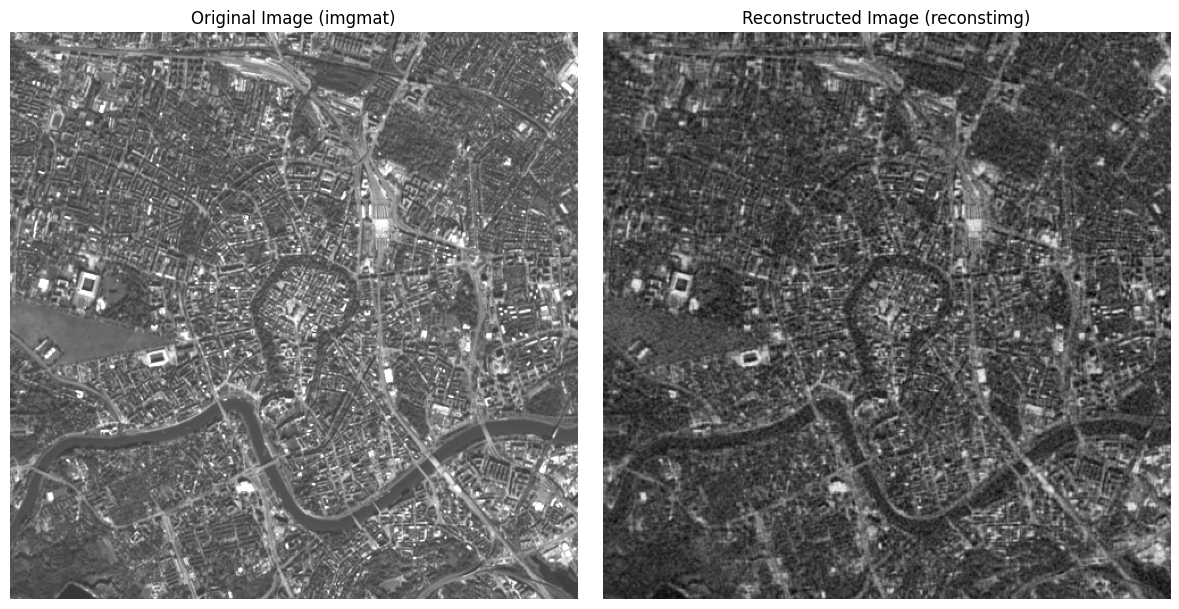

In [32]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imgmat, cmap='gray')
plt.title("Original Image (imgmat)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(reconstimg, cmap='gray')
plt.title("Reconstructed Image (reconstimg)")
plt.axis("off")
plt.tight_layout()
plt.show()

Now lets do the same for more vegegetation-rich area, I picked Puszcza Niepoomicka from the same sentinel-2 image (to the south-east of Krakow)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.59949464..2.7795324].


Found bands: {'B04': '/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B04_10m.jp2', 'B03': '/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B03_10m.jp2', 'B02': '/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B02_10m.jp2'}


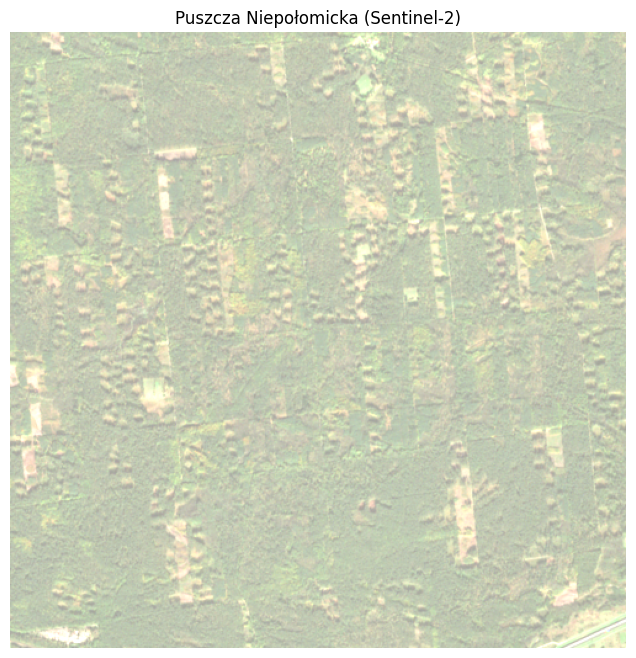

In [33]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from pyproj import Transformer

folder = "/home/scoora/studies/ml/lab_01/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/"

band_paths = {b: glob.glob(f"{folder}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
print("Found bands:", band_paths)
lon, lat = 20.3591, 50.0197   # Puszcza Niepołomicka
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 2500   
dy = 2500
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

nir_crop   = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax))
red_crop   = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax))
green_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax))
rgb = np.dstack((nir_crop, red_crop, green_crop)).astype(np.float32)
rgb /= np.percentile(rgb, 99) 
rgb_clip = np.clip(rgb, 0, 1) 
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Puszcza Niepołomicka (Sentinel-2)")
plt.axis("off")
plt.show()


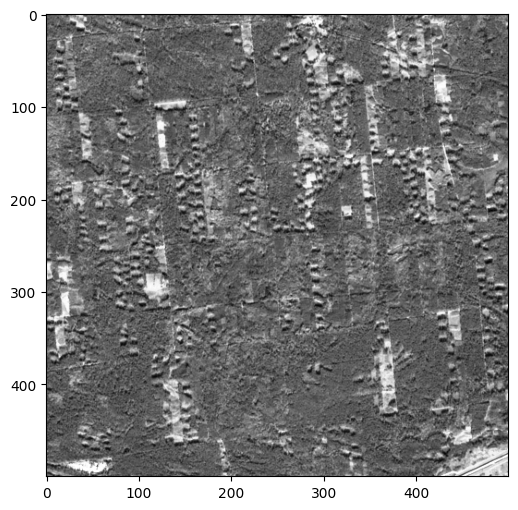

In [34]:
from PIL import Image
import numpy as np
#for the code before we need to transform the numpy array we have to the PIL image 
rgb_uint8 = (rgb_clip * 255).astype(np.uint8)
img = Image.fromarray(rgb_uint8)

##and as before:
imggray = img.convert('L')
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray')

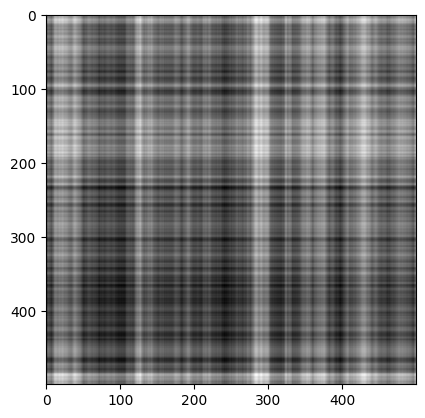

In [35]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

(500, 500)
(500,)


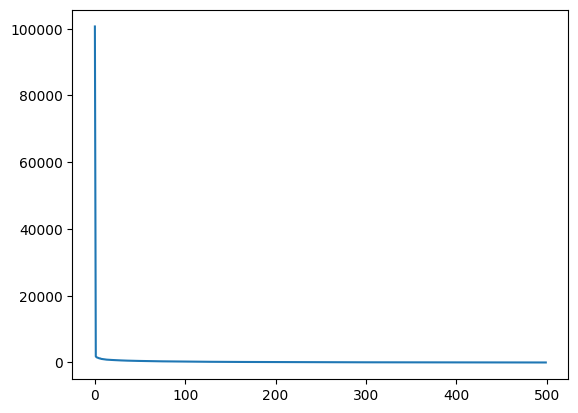

In [36]:
print(U.shape)
print(sigma.shape)
plt.plot(sigma)

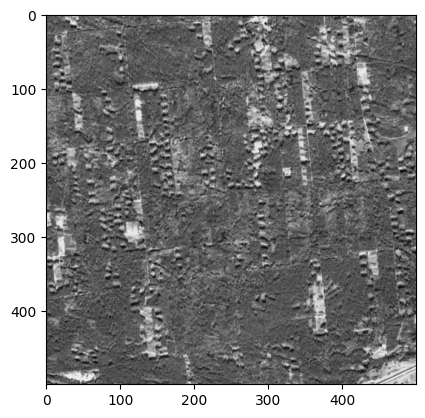

In [37]:
i = 200
j = 0
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

Well it doesn't look good but what more can we get from 10x10m spatial resolution, still the svd works

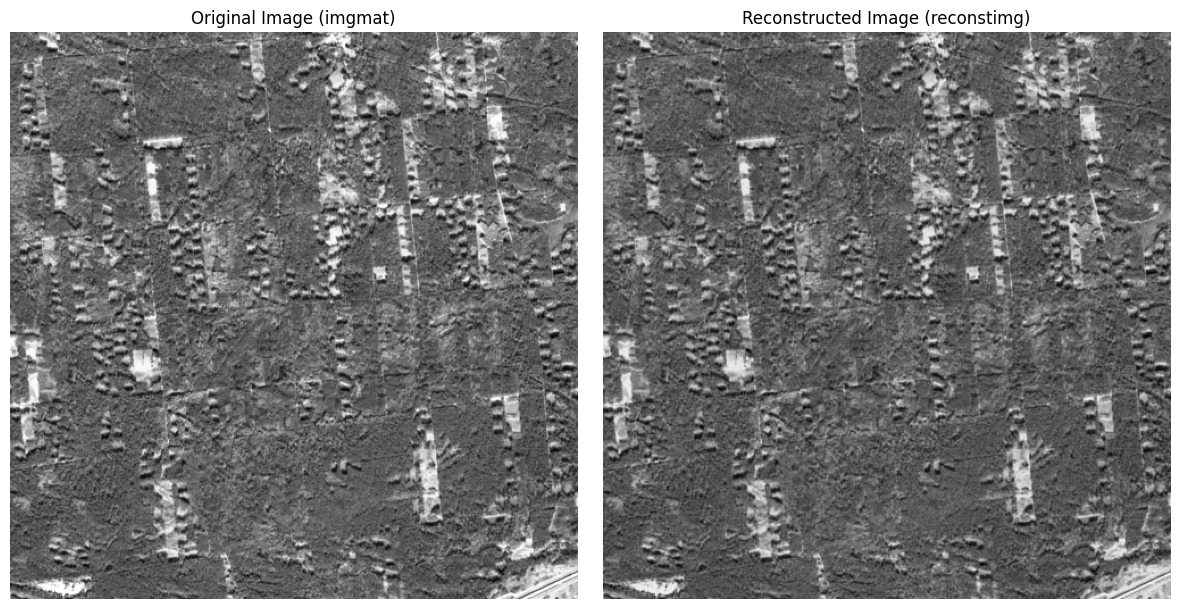

In [38]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imgmat, cmap='gray')
plt.title("Original Image (imgmat)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(reconstimg, cmap='gray')
plt.title("Reconstructed Image (reconstimg)")
plt.axis("off")
plt.tight_layout()
plt.show()